MCA https://github.com/MaxHalford/Prince#multiple-correspondence-analysis-mca
Kramers V https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
KMedoids https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c tabular-playground-series-may-2021

kaggle.json
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!pip install catboost
!pip install eli5
!pip install shap
!pip install scikit-learn-extra
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip
!unzip /content/sample_submission.csv.zip

Archive:  /content/test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
Archive:  /content/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train.csv               
Archive:  /content/sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, FactorAnalysis as FA
from typing import List, Optional
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from typing import List, Tuple
import scipy.stats as ss
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.utils.validation import check_is_fitted
import eli5
from sklearn.base import BaseEstimator, TransformerMixin
import time
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import shap
import missingno as msno
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split, KFold

In [ ]:
def get_input(data_path: str) -> pd.DataFrame:
  """
  Считывание данных и вывод основной информации о наборе данных.

  Parmeters
  ---------
  data_path: str - название файла

  Returns
  -------
  data: pandas.core.frame.DataFrame - загруженный набор данных в pandas.Dataframe
  """
  base_path = "/content"
  data = pd.read_csv(f"{base_path}/{data_path}")
  data.columns = [col.lower() for col in data.columns]
  print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
  return data

In [ ]:
def plot_feature_importance(importance, names, model_type, figsize=(10,8)):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=figsize)
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  return list(fi_df['feature_names'].values)

In [ ]:
data = get_input("train.csv")
test = get_input("test.csv")
sample_submission = get_input("sample_submission.csv")

train.csv: shape = 100000 rows, 52 cols
test.csv: shape = 50000 rows, 51 cols
sample_submission.csv: shape = 50000 rows, 5 cols


In [ ]:
(data.loc[data.target == 'Class_2'][columns] != 0).sum(axis=1).mean()
(data.loc[data.target == 'Class_3'][columns] != 0).sum(axis=1).mean()
(data.loc[data.target == 'Class_4'][columns] != 0).sum(axis=1).mean()
data.loc[data.target == 'Class_2'][columns].sum(axis=1).mean()
data.loc[data.target == 'Class_3'][columns].sum(axis=1).mean()
data.loc[data.target == 'Class_4'][columns].sum(axis=1).mean()
data.loc[data.target == 'Class_1'][columns].sum(axis=1).var()

10.41127363166774

## Логистическая регрессия (одиночная модель)

In [ ]:
mapper = {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}
data['target'] = data['target'].map(mapper)

train, valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1,
)

y_train = train['target']
x_train = train.drop(columns=['target'])
y_valid = valid['target']
x_valid = valid.drop(columns=['target'])

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
clf = LogisticRegression(random_state=0, max_iter=100, multi_class='multinomial', solver='lbfgs')
clf.fit(x_train, y_train)
y_pred = clf.predict_proba(x_valid)
log_loss = metrics.log_loss(y_valid, y_pred)
log_loss

1.1064099714808213

In [ ]:
clf = SGDClassifier(loss='log', max_iter=2000, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict_proba(x_valid)
log_loss = metrics.log_loss(y_valid, y_pred)
log_loss

1.1267401361121265

## Логистическая регрессия (кросс валидация)

In [ ]:
def logistic_cv_fit(params, X, y, cv):
    """
    Кросс-валидация для модели LogisticRegression.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """

    estimators, folds_scores, scalers = [], [], []
    oof_preds = np.zeros((X.shape[0], 4))
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_valid = scaler.transform(x_valid)
        model = LogisticRegression(**params)
        model.fit(x_train, y_train)
        oof_preds[valid_idx] = model.predict_proba(x_valid)
        score = metrics.log_loss(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
        scalers.append(scaler)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds, scalers

In [ ]:
data = get_input("train.csv")
test = get_input("test.csv")
sample_submission = get_input("sample_submission.csv")

mapper = {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}
data['target'] = data['target'].map(mapper)

train, valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1,
)

train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

y_train = train['target']
x_train = train.drop(columns=['target'])
y_valid = valid['target']
x_valid = valid.drop(columns=['target'])

train.csv: shape = 100000 rows, 52 cols
test.csv: shape = 50000 rows, 51 cols
sample_submission.csv: shape = 50000 rows, 5 cols


In [ ]:
params = {'random_state': 0, 
          'max_iter': 100, 
          'multi_class': 'multinomial', 
          'solver': 'lbfgs'}

cv = StratifiedKFold(n_splits=7, random_state=435, shuffle=True)
estimators, oof_preds, scalers = logistic_cv_fit(params, x_train, y_train, cv)

Thu May  6 12:48:05 2021, Cross-Validation, 70000 rows, 51 cols
Fold 1, Valid score = 1.10751
Fold 2, Valid score = 1.1087
Fold 3, Valid score = 1.10487
Fold 4, Valid score = 1.1065
Fold 5, Valid score = 1.10863
Fold 6, Valid score = 1.1091
Fold 7, Valid score = 1.10905
Score by each fold: [1.10751, 1.1087, 1.10487, 1.1065, 1.10863, 1.1091, 1.10905]


In [ ]:
metrics.log_loss(y_train, oof_preds)

1.1077632439093126

In [ ]:
def multi_estimators_predict(estimators: List,
                             x_valid: pd.DataFrame,
                             y_valid: pd.Series,
                             metric: callable,
                             scalers: List = None,
                             eval_each_estimator: bool = True,
                             eval_result_estimator: bool = True):
  preds = []
  evals = []
  if scalers:
    assert len(estimators) == len(scalers)

  for i in range(len(estimators)):
    if scalers:
      pred = estimators[i].predict_proba(scalers[i].transform(x_valid))
    else:
      pred = estimators[i].predict_proba(x_valid)
    eval = metric(y_valid, pred)
    preds.append(pred)
    evals.append(eval)
  
  result = np.stack([preds], axis=0)
  result = np.squeeze(result, axis=0)
  result = np.mean(result, axis=0)

  if eval_each_estimator:
    for i, eval in enumerate(evals):
      print(f"Model {i} metric: {eval:.7}")
  
  if eval_result_estimator:
    print(f"Result model metric: {metric(y_valid, result):.7}")

  return result

In [ ]:
def multi_estimators_predict(estimators: List,
                             x_valid: pd.DataFrame,
                             y_valid = None,
                             metric: callable = None,
                             scalers: List = None):
  preds = []
  evals = []
  if scalers:
    assert len(estimators) == len(scalers)

  for i in range(len(estimators)):
    if scalers:
      pred = estimators[i].predict_proba(scalers[i].transform(x_valid))
    else:
      pred = estimators[i].predict_proba(x_valid)
    
    preds.append(pred)
    if (y_valid is not None) and (metric is not None):
      eval = metric(y_valid, pred)
      evals.append(eval)
  
  result = np.stack([preds], axis=0)
  result = np.squeeze(result, axis=0)
  result = np.mean(result, axis=0)

  if (y_valid is not None) & (metric is not None):
    for i, eval in enumerate(evals):
      print(f"Model {i} metric: {eval:.7}")
    print(f"Result model metric: {metric(y_valid, result):.7}")

  return result

In [ ]:
result = multi_estimators_predict(estimators, x_valid, y_valid, metrics.log_loss, scalers)

Model 0 metric: 1.106636
Model 1 metric: 1.106441
Model 2 metric: 1.106707
Model 3 metric: 1.106694
Model 4 metric: 1.106466
Model 5 metric: 1.10647
Model 6 metric: 1.106833
Result model metric: 1.106404


## Градиентный бустнинг

In [ ]:
data = get_input("train.csv")
test = get_input("test.csv")
sample_submission = get_input("sample_submission.csv")

data.drop(columns='id', inplace=True)

mapper = {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}
data['target'] = data['target'].map(mapper)

train.csv: shape = 100000 rows, 52 cols
test.csv: shape = 50000 rows, 51 cols
sample_submission.csv: shape = 50000 rows, 5 cols


In [ ]:
data['sum'] = data[data.columns.to_list()[:50]].sum(axis=1) # норм
data['max'] = data[data.columns.to_list()[:50]].max(axis=1) # норм
data['not_nul_features'] = (data!=0)[data.columns.to_list()[:50]].sum(axis=1)

In [ ]:
def add_sum_feature(data: pd.DataFrame, feature: str):
  columns = data.columns.to_list()[:50]
  for column in columns:
    data[f'{feature} + {column}'] = data[feature] + data[column]

In [ ]:
def add_sum_feature(data: pd.DataFrame):
  columns = data.columns.to_list()[:50]
  for i in range(len(columns)-2):
    for j in range(i+1, len(columns)-1):
      data[f"feature_{i}+feature_{j}"] = data[f"feature_{i}"] + data[f"feature_{j}"]

In [ ]:
#add_sum_feature(data)
add_sum_feature(data, 'feature_6')

In [ ]:
# очень хороши
#2+13
#6+15

data['2+13'] = data['feature_2'] + data['feature_13']
data['6+15'] = data['feature_6'] + data['feature_15']

#data['0+15'] = data['feature_0'] + data['feature_15']

#data['2+14'] = data['feature_2'] + data['feature_14']
#data['2+6'] = data['feature_2'] + data['feature_6']
#data['2+15'] = data['feature_2'] + data['feature_15']
#data['14+6'] = data['feature_14'] + data['feature_6']
#data['14+15'] = data['feature_14'] + data['feature_15']
#data['14+13'] = data['feature_14'] + data['feature_13']
#data['6+13'] = data['feature_6'] + data['feature_13']

In [ ]:
train, valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1,
)

train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

y_train = train['target']
x_train = train.drop(columns=['target'])
y_valid = valid['target']
x_valid = valid.drop(columns=['target'])

In [ ]:
def cramers_v(x, y):
#https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
class MakePCA(BaseEstimator, TransformerMixin):

    def __init__(self, scaler=StandardScaler(), 
                 n_components: int = 10,
                 random_state: int = 42):
      
      self.scaler = scaler
      self.pca = PCA(n_components=n_components, random_state=random_state)

    def fit(self, X: pd.DataFrame):
      self.pca.fit(self.scaler.fit_transform(X))
      self.fitted = True
      return self

    def transform(self, X: pd.DataFrame):
      check_is_fitted(self, "fitted")
      X_PCA = self.pca.transform(self.scaler.transform(X))
      X_PCA = pd.DataFrame(X_PCA)
      mapper = {}
      for i in range(X_PCA.shape[1]):
        mapper[i] = f'PCA_{i}'
      X_PCA.rename(columns=mapper, inplace=True)
      X = pd.concat([X, X_PCA], axis=1)
      return X

In [ ]:
my_PCA = MakePCA(scaler=StandardScaler(), n_components=5)
x_train = my_PCA.fit_transform(x_train)
x_valid = my_PCA.transform(x_valid)

In [ ]:
class MakeClusters(BaseEstimator):

    def __init__(self, scaler=StandardScaler(), 
                 clusterer=KMeans(n_clusters=4), 
                 cluster_column_name: str = 'cluster'):
      
      self.scaler = scaler
      self.clusterer = clusterer
      self.cluster_column_name = cluster_column_name

    def fit(self, X: pd.DataFrame):
      self.clusterer.fit(self.scaler.fit_transform(X))
      self.fitted = True
      return self

    def transform(self, X: pd.DataFrame, y: pd.Series=None):
      check_is_fitted(self, "fitted")
      clusters = self.clusterer.predict(self.scaler.transform(X))
      X[self.cluster_column_name] = clusters
      if y is not None:
        print(f"Cramer V test: {cramers_v(clusters, y.values):.5}")
    
    def fit_transform(self, X: pd.DataFrame, y: pd.Series=None):
      clusters = self.clusterer.fit_predict(self.scaler.fit_transform(X))
      X[self.cluster_column_name] = clusters
      self.fitted = True
      if y is not None:
        print(f"Cramer V test: {cramers_v(clusters, y.values):.5}")

In [ ]:
x_train_pca = x_train[x_train.columns.to_list()[50:80]]

In [ ]:
my_clusterer = MakeClusters(StandardScaler(), 
                            KMeans(n_clusters=4, random_state=0, max_iter=600), 
                            #KMedoids(n_clusters=4, random_state=0, max_iter=600), 
                            cluster_column_name = 'claster')
#my_clusterer.fit(x_train)
#my_clusterer.transform(x_train, y_train)
my_clusterer.fit_transform(x_train, y_train)

In [ ]:
def plot_cramers_corr_matrics(data: pd.DataFrame):
  matrix = np.zeros((data.shape[1], data.shape[1]))
  columns = data.columns.to_list()
  for i in range(data.shape[1]):
    for j in range(i, data.shape[1]):
      matrix[i, j] = cramers_v(data[columns[i]], data[columns[j]])
      matrix[j, i] = matrix[i, j]
  matrix_df = pd.DataFrame(data=matrix, index=columns, columns=columns)
  fig, axes = plt.subplots(figsize = (14,12))
  plt.title("Features correlation", y=1, size=16)
  sns.heatmap(matrix_df, square=True, vmax=0.8, cmap="viridis")

In [ ]:
plot_kramers_corr_matrics(data)

In [ ]:
def lightgbm_cv_fit(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели lightgbm.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros((X.shape[0], 4))
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="multi_logloss", verbose=10, early_stopping_rounds=50,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)
        score = metrics.log_loss(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

### Выбор категориальных признаков среди порядковых

In [ ]:
def get_nunique(df: pd.DataFrame) -> pd.DataFrame:
  result = {}
  columns = df.columns.to_list()
  for feature in columns:
    result[feature] = train[feature].nunique()
  return result

In [ ]:
n_unique = get_nunique(data.drop(columns='target'))
n_unique = pd.DataFrame.from_dict(data = n_unique, orient='index')
n_unique.rename(columns={0:'n_unique'}, inplace=True)
n_unique.sort_values(by='n_unique', ascending=True, inplace=True)

categorical_feature_names = list(n_unique[n_unique.n_unique < 15].index)
categorical_feature_names

In [ ]:
categorical_feature_names = ['feature_13', 'feature_2', 'feature_22', 'feature_36']
categorical_feature_names = ['feature_13', 'feature_2', 'feature_22', 'feature_36', 'feature_5', 'feature_44',
                             'feature_0', 'feature_12', 'feature_11', 'feature_29', 'feature_18']

for feature in categorical_feature_names:
  x_train[feature] = pd.Series(x_train[feature], dtype="category")
  x_valid[feature] = pd.Series(x_valid[feature], dtype="category")

Вывод: категориальные признаки не дали улучшений

### Обучение модели

In [ ]:
lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "learning_rate": 0.12,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu',
    'num_class': 4,
    'random_state': 2
}

cv = StratifiedKFold(n_splits=7, random_state=435, shuffle=True)

lgb_estimators, lgb_oof = lightgbm_cv_fit(
    lgbm_params, x_train, y_train, cv, #categorical=categorical_feature_names
)

Thu May 13 11:17:52 2021, Cross-Validation, 70000 rows, 55 cols
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's multi_logloss: 1.10849
[20]	valid_0's multi_logloss: 1.10467
[30]	valid_0's multi_logloss: 1.10219
[40]	valid_0's multi_logloss: 1.10075
[50]	valid_0's multi_logloss: 1.09931
[60]	valid_0's multi_logloss: 1.09825
[70]	valid_0's multi_logloss: 1.09751
[80]	valid_0's multi_logloss: 1.09672
[90]	valid_0's multi_logloss: 1.09612
[100]	valid_0's multi_logloss: 1.09557
[110]	valid_0's multi_logloss: 1.0951
[120]	valid_0's multi_logloss: 1.09477
[130]	valid_0's multi_logloss: 1.09444
[140]	valid_0's multi_logloss: 1.0942
[150]	valid_0's multi_logloss: 1.0939
[160]	valid_0's multi_logloss: 1.09367
[170]	valid_0's multi_logloss: 1.09357
[180]	valid_0's multi_logloss: 1.09346
[190]	valid_0's multi_logloss: 1.0934
[200]	valid_0's multi_logloss: 1.09332
[210]	valid_0's multi_logloss: 1.09321
[220]	valid_0's multi_logloss: 1.09317
[230]	valid_0's multi_logloss

In [ ]:
print(f"Out of fold ROC AUC {metrics.log_loss(y_train, lgb_oof)}")

Out of fold ROC AUC 1.0937572220108407


In [ ]:
result = multi_estimators_predict(lgb_estimators, x_valid, y_valid, metrics.log_loss)

Model 0 metric: 1.091996
Model 1 metric: 1.092125
Model 2 metric: 1.091926
Model 3 metric: 1.092687
Model 4 metric: 1.092034
Model 5 metric: 1.091719
Model 6 metric: 1.092089
Result model metric: 1.090895


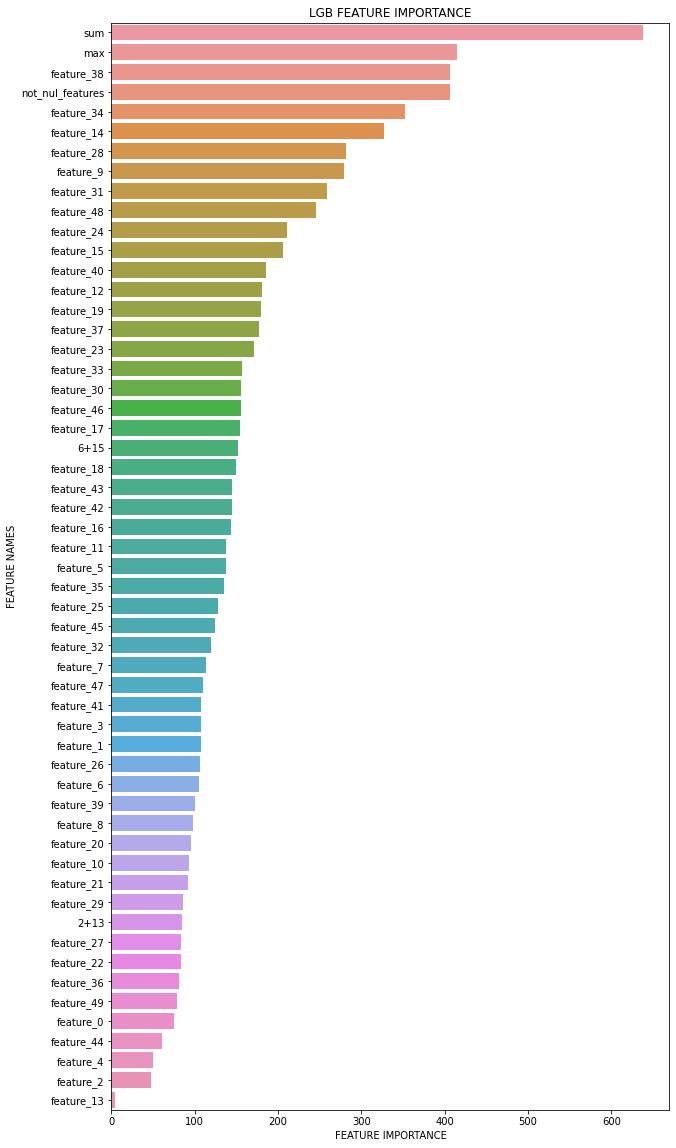

In [ ]:
top_features = plot_feature_importance(lgb_estimators[0].feature_importances_, x_valid.columns, 'LGB', figsize=(10,20))

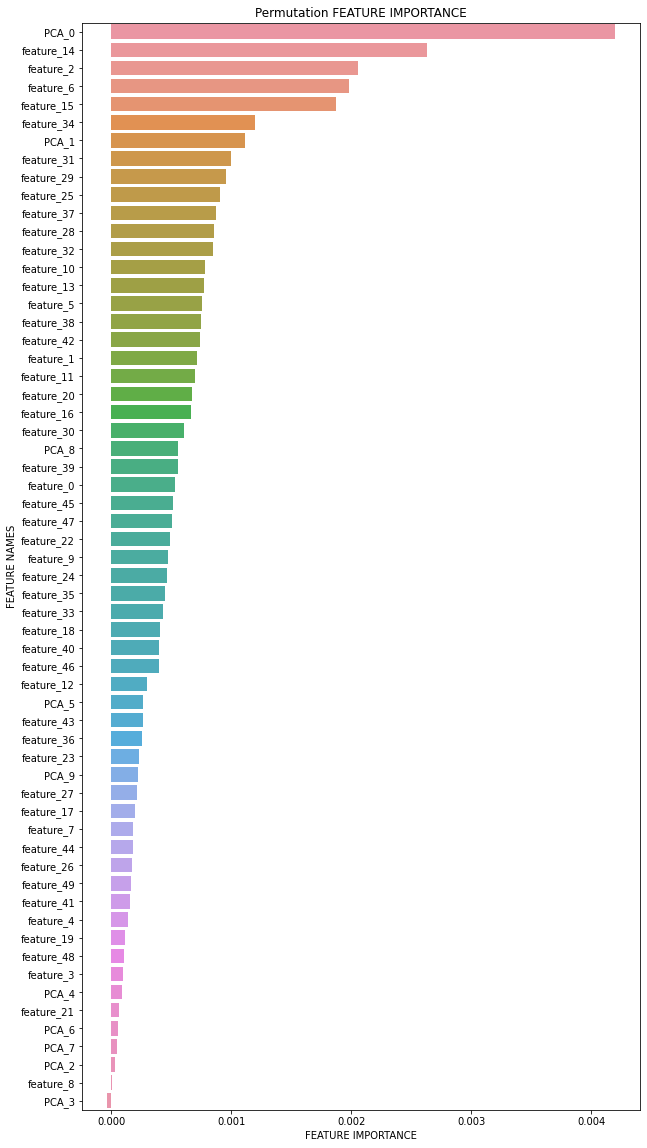

In [ ]:
importance = permutation_importance(lgb_estimators[0], x_valid, y_valid, scoring='neg_log_loss', n_jobs=6, random_state=27)
top_features = plot_feature_importance(importance['importances_mean'], x_valid.columns, 'Permutation', figsize=(10,20))

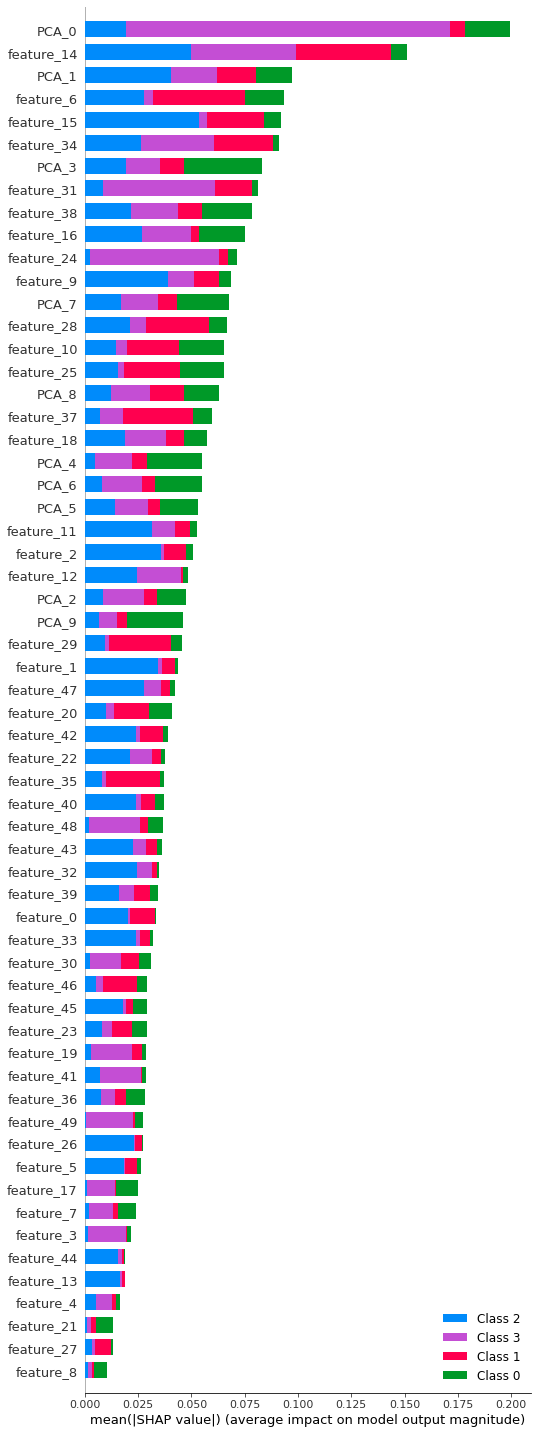

In [ ]:
explainer = shap.TreeExplainer(lgb_estimators[0])
shap_values = explainer.shap_values(x_valid, y_valid)
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

In [ ]:
def get_shap_feature_importance_df(shap_values: List, columns: List):
  res = 0
  for s_values_for_class in shap_values:
    res = res + np.abs(s_values_for_class)
  res = np.mean(res, axis=0)
  res = pd.DataFrame(res)
  res['features'] = columns
  res.rename(columns={0:'value'}, inplace=True)
  res = res.sort_values(by='value', ascending=False)
  return res

In [ ]:
res = get_shap_feature_importance_df(shap_values, x_valid.columns.to_list())

In [ ]:
res.head(5)

,value,features
52,0.143199,not_nul_features
50,0.075227,sum
158,0.052042,feature_2+feature_13
348,0.046927,feature_6+feature_29
110,0.040803,feature_1+feature_11


In [ ]:
top_200 = res['features'].values[:200]

In [ ]:
top_200

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(max_depth=15, random_state=0, n_estimators=300)
rf_model.fit(x_train, y_train)
result = rf_model.predict_proba(x_valid)

In [ ]:
metrics.log_loss(y_valid, result)

1.102588665090751

## Получение результата

### Линейная модель

In [ ]:
test_st = scaler.transform(test)
test_pred = clf.predict_proba(test_st)
test_pred_df = pd.DataFrame(test_pred)
test_pred_df.rename(columns={0:'class_1',	1:'class_2',	2:'class_3',	3:'class_4'}, inplace=True)
result = test.drop(columns = test.columns.to_list()[1:])
result = pd.concat([result, test_pred_df], axis=1)
result.to_csv('result.csv', index=False)

### Бустинг

In [ ]:
data = get_input("train.csv")
test = get_input("test.csv")
data.drop(columns='id', inplace=True)
sample_submission = get_input("sample_submission.csv")

data['mean'] = data[data.columns.to_list()[:-1]].mean(axis=1)
data['max'] = data[data.columns.to_list()[:-1]].max(axis=1)

test['mean'] = test[test.columns.to_list()[1:-1]].mean(axis=1)
test['max'] = test[test.columns.to_list()[1:-1]].max(axis=1)

mapper = {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}
data['target'] = data['target'].map(mapper)

y_train = data['target']
x_train = data.drop(columns=['target'])

train.csv: shape = 100000 rows, 52 cols
test.csv: shape = 50000 rows, 51 cols
sample_submission.csv: shape = 50000 rows, 5 cols


In [ ]:
lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "learning_rate": 0.1,
    "num_boost_round ": 1000,
    "reg_lambda": 100,
    "max_depth": 5,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu',
    'num_class': 4,
    'random_state': 1
}

cv = StratifiedKFold(n_splits=7, random_state=435, shuffle=True)


lgb_estimators, lgb_oof = lightgbm_cv_fit(
    lgbm_params, x_train, y_train, cv
)

print(f"Out of fold ROC AUC {metrics.log_loss(y_train, lgb_oof)}")
result = multi_estimators_predict(lgb_estimators, test.drop(columns='id'))
test_pred_df = pd.DataFrame(result)
test_pred_df.rename(columns={0:'class_1',	1:'class_2',	2:'class_3',	3:'class_4'}, inplace=True)
result = test.drop(columns = test.columns.to_list()[1:])
result = pd.concat([result, test_pred_df], axis=1)
result.to_csv('result.csv', index=False)

In [ ]:
def greedy_lgbm_categorical_finder(data: pd.DataFrame,
                         target: str,
                         lgb_params: dict) -> dict:
  """
  Жадный поиск категориальных признаков на основе lightgbm в датасете.

  Parameters
  ----------
  data: pandas.core.frame.DataFrame
    Исходный датасет.
  
  target: str
    Название целевой переменной
  
  lgb_params: dict
    Параметры модели lightgbm

  Returns
  -------
  result: dict
    Значения качества модели при выборе данного признака категориальным.
  """

  result = {}

  train, valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1,
  )

  y_train = train[target]
  x_train = train.drop(columns=target)
  y_valid = valid[target]
  x_valid = valid.drop(columns=target)

  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid)

  model_lgbm =  lgb.train(lgb_params,
                lgb_train,
                valid_sets=lgb_eval,
                verbose_eval=False, 
                num_boost_round=10000,
                early_stopping_rounds=100)

  result['initial'] = model_lgbm.best_score['valid_0']['multi_logloss']
                       #'best iteration': model_lgbm.best_iteration_}
  
  print("="*50)
  print(f"Initial dataset: best score {model_lgbm.best_score['valid_0']['multi_logloss']}, best iteration {model_lgbm.best_iteration}")
  print("="*50)

  features = x_train.columns.to_list()
  
  for feature in features:
    categorical_feature_names = []
    y_train = train[target]
    x_train = train.drop(columns=target)
    y_valid = valid[target]
    x_valid = valid.drop(columns=target)
    
    x_train[feature] = pd.Series(x_train[feature], dtype="category")
    x_valid[feature] = pd.Series(x_valid[feature], dtype="category")
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid)
    categorical_feature_names.append(feature)


    model_lgbm =  lgb.train(lgbm_params,
                  lgb_train,
                  valid_sets=lgb_eval,
                  verbose_eval=False, 
                  categorical_feature=categorical_feature_names,
                  num_boost_round=10000,
                  early_stopping_rounds=100)


    print(f"Cat feature {feature}: best score {model_lgbm.best_score['valid_0']['multi_logloss']}, best iteration {model_lgbm.best_iteration}")
    result[f'Cat feature {feature}'] = model_lgbm.best_score['valid_0']['multi_logloss']

  return result

In [ ]:
greedy_lgbm_categorical_finder(data, 'target', lgbm_params)

Если каждый признак по очереди сделать категориальным, то точность уменьшится